In [43]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [44]:
from utils.common import sigmoid, reverse_sigmoid

In [45]:
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"

In [46]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [47]:
result_sub1 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission25_0.799.csv")
result_sub1["prediction"] = result_sub1["prediction"].apply(reverse_sigmoid)

In [48]:
result_sub2 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission19_0.796.csv")

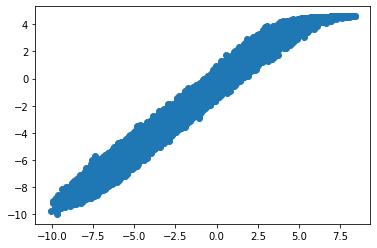

In [49]:
plt.scatter(result_sub2["prediction"], result_sub1["prediction"])
plt.show()

In [50]:
np.corrcoef(result_sub2["prediction"], result_sub1["prediction"])

array([[1.        , 0.99493318],
       [0.99493318, 1.        ]])

In [51]:
merged_result = result_sub1.merge(result_sub2, on="customer_ID", how="left")

#### Take weighted average of 2 prediction scores

In [52]:
merged_result["prediction"] = merged_result["prediction_x"].rank() * 0.7 + merged_result["prediction_y"].rank() * 0.3
# merged_result["prediction"] = 0.6 * merged_result["prediction_x"] + 0.4 * merged_result["prediction_y"]

In [53]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"], errors="ignore")

In [54]:
if merged_result.shape == (924621, 2) and merged_result.columns.tolist() == ['customer_ID', 'prediction']:
    merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission31.csv", index=False)

In [48]:
merged_result["x_positive"] = (merged_result["prediction_x"] >= 0)

In [49]:
merged_result["y_positive"] = (merged_result["prediction_y"] >= 0)

In [50]:
neg_neg_indices = merged_result.loc[(~merged_result["x_positive"]) & (~merged_result["y_positive"])].index

In [51]:
merged_result.loc[neg_neg_indices, "prediction"] = merged_result.loc[neg_neg_indices, :].min(axis=1)

In [52]:
pos_pos_indices = merged_result.loc[(merged_result["x_positive"]) & (merged_result["y_positive"])].index

In [53]:
merged_result.loc[pos_pos_indices, "prediction"] = merged_result.loc[pos_pos_indices, :].max(axis=1)

In [54]:
merged_result["prediction"].isnull().sum()

25395

In [55]:
merged_result.loc[merged_result["prediction"].isnull(), "prediction"] = \
(merged_result.loc[merged_result["prediction"].isnull(), "prediction_x"] + \
merged_result.loc[merged_result["prediction"].isnull(), "prediction_y"]) / 2

In [56]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"])

In [58]:
merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission24.csv", index=False)

In [20]:
new_result_sub["prediction"] = np.max([new_result_sub["prediction"].values, old_result_sub["prediction"].values], axis=0)

In [27]:
new_result_sub["prediction"] += old_result_sub["prediction"]

In [28]:
new_result_sub["prediction"] /= 2

In [30]:
new_result_sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission22.csv", index=False)

In [ ]:
result_sub = test_agg.loc[:, [c for c in test_agg.columns if c.startswith("score")]].mean(axis=1).reset_index()

In [ ]:
result_sub.columns = ["customer_ID", "prediction"]

In [ ]:
result_sub.to_csv("submission20.csv", index=False)

In [ ]:
single_record_index = test_agg.loc[test_agg["num_records"] == 1].index.tolist()

In [ ]:
final_df13 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission13_0.796.csv")
final_df13["prediction_13"] = sigmoid(final_df13["prediction"])
final_df13 = final_df13.drop(columns="prediction")

In [ ]:
final_df16 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission16_0.782.csv")
final_df16["prediction_16"] = sigmoid(final_df16["prediction"])
final_df16 = final_df16.drop(columns="prediction")

In [ ]:
mega_df = final_df13.merge(final_df16, on="customer_ID", how="left")

In [ ]:
mega_df.loc[:, "prediction"] = (
    mega_df.loc[:, "prediction_16"] * 0.1 \
    + mega_df.loc[:, "prediction_13"] * 0.9
)

In [ ]:
mega_df.loc[single_record_index, "prediction"] = (
    mega_df.loc[single_record_index, "prediction_16"] * 0.8 \
    + mega_df.loc[single_record_index, "prediction_13"] * 0.2
)

In [ ]:
mega_df = mega_df.drop(columns=["prediction_13", "prediction_16"])

In [ ]:
mega_df["prediction"] = 0.55 * mega_df["prediction_x"] + 0.45 * mega_df["prediction_y"]
mega_df = mega_df.drop(columns=["prediction_x", "prediction_y"])

In [ ]:
mega_df.to_csv(f"{SUBMISSION_DATA_PATH}/submission18.csv", index=False)